<a href="https://colab.research.google.com/github/ranja-sarkar/SVM/blob/main/1cSVM_dat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Data

In [27]:
kddcup = sklearn.datasets.fetch_kddcup99(random_state = 42, percent10 = True)
train = pd.DataFrame(kddcup.data, columns = kddcup.feature_names)

dff = train.head(104000)

In [28]:
dff.info()  #reduced datasize #downsizing from ~150 MB to ~30MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104000 entries, 0 to 103999
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   duration                     104000 non-null  object
 1   protocol_type                104000 non-null  object
 2   service                      104000 non-null  object
 3   flag                         104000 non-null  object
 4   src_bytes                    104000 non-null  object
 5   dst_bytes                    104000 non-null  object
 6   land                         104000 non-null  object
 7   wrong_fragment               104000 non-null  object
 8   urgent                       104000 non-null  object
 9   hot                          104000 non-null  object
 10  num_failed_logins            104000 non-null  object
 11  logged_in                    104000 non-null  object
 12  num_compromised              104000 non-null  object
 13  root_shell    

In [29]:
dff.nunique()

,0
duration,233
protocol_type,3
service,63
flag,11
src_bytes,2674
dst_bytes,9202
land,2
wrong_fragment,3
urgent,4
hot,17


In [30]:
dff.columns[(dff == 0).all()]

Index(['num_outbound_cmds', 'is_host_login'], dtype='object')

In [31]:
dff = dff.drop(['num_outbound_cmds', 'is_host_login'], axis = 1)

In [32]:
cols = ['serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']

dff[cols] = np.array(dff[cols], dtype = float)

In [33]:
cols0 = ['duration', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_guest_login', 'count', 'srv_count',
         'dst_host_count', 'dst_host_srv_count']

dff[cols0] = np.array(dff[cols0], dtype = int)

In [34]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104000 entries, 0 to 103999
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     104000 non-null  int64  
 1   protocol_type                104000 non-null  object 
 2   service                      104000 non-null  object 
 3   flag                         104000 non-null  object 
 4   src_bytes                    104000 non-null  int64  
 5   dst_bytes                    104000 non-null  int64  
 6   land                         104000 non-null  int64  
 7   wrong_fragment               104000 non-null  int64  
 8   urgent                       104000 non-null  int64  
 9   hot                          104000 non-null  int64  
 10  num_failed_logins            104000 non-null  int64  
 11  logged_in                    104000 non-null  int64  
 12  num_compromised              104000 non-null  int64  
 13 

In [35]:
feats = ['protocol_type', 'service', 'flag']

def categorical_df_to_numerical(df):
    df_one_hot = dff.copy()

    for sf_name in reversed(feats):
        dum = pd.get_dummies(df[sf_name])
        dum.columns = sf_name + "__" + dum.columns.map(str)

        df_one_hot = pd.concat([dum, df_one_hot], axis = 1)
        df_one_hot.drop([sf_name], axis = 1, inplace = True)

    return df_one_hot

In [36]:
df_one_hot = categorical_df_to_numerical(dff)
len(df_one_hot.columns)

113

In [37]:
scaler = StandardScaler()
scaler.fit(df_one_hot)

df_train = scaler.transform(df_one_hot)

In [38]:
print(df_train.shape)

(104000, 113)


# Model

>> https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

In [39]:
clf = OneClassSVM(nu = 0.05, tol = 0.005).fit(df_train)

In [40]:
clf.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.05,
 'shrinking': True,
 'tol': 0.005,
 'verbose': False}

In [41]:
pred = clf.predict(df_train)
(pred.tolist()).count(-1)

5186

In [42]:
clf.decision_function(df_train)

array([ 98.47218914,  99.45134116, 100.64362465, ...,   8.05307013,
         7.88774717,   7.32906454])

>> Outputs distance of each datapoint from the separating hyperplane ⏫

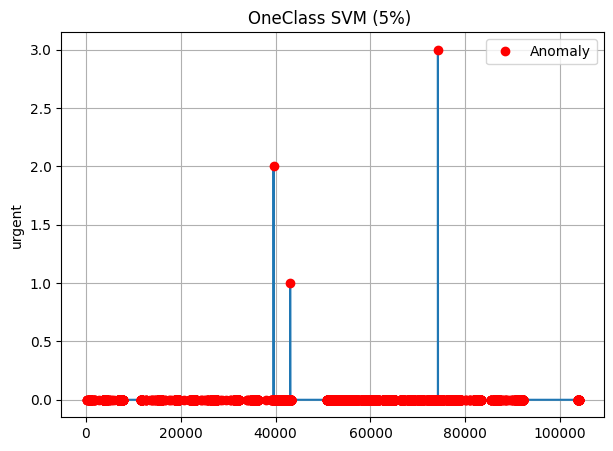

In [44]:
df_one_hot['anomaly_value'] = pred
anomalies = df_one_hot.loc[df_one_hot['anomaly_value'] == -1]

plt.figure(figsize = (7, 5))
plt.plot(df_one_hot['urgent'])
plt.plot(anomalies['urgent'], 'o', color = 'red', label = 'Anomaly')
plt.title('OneClass SVM (5%) ')
plt.grid()
plt.ylabel('urgent')
plt.legend()

# Hyper-parameter Tuning

In [45]:
clf1 = OneClassSVM(nu = 0.01, tol = 0.005).fit(df_train)

In [46]:
pred1 = clf1.predict(df_train)
(pred1.tolist()).count(-1)

1150

In [47]:
clf1.decision_function(df_train)

array([4.39726675, 4.41186555, 4.44486587, ..., 1.64810635, 1.64016991,
       1.65139788])

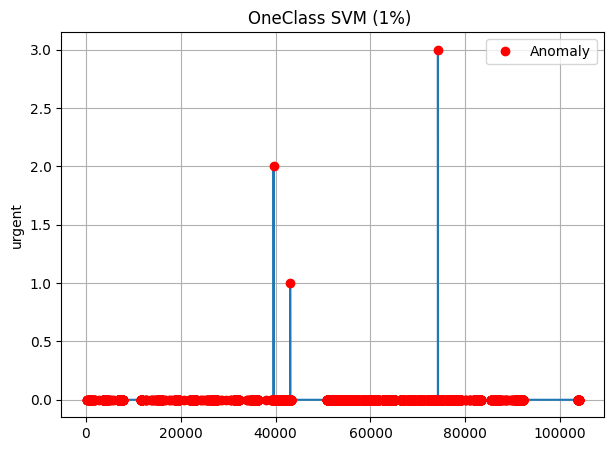

In [48]:
df_one_hot['anomaly_value'] = pred
anomalies = df_one_hot.loc[df_one_hot['anomaly_value'] == -1]

plt.figure(figsize = (7, 5))
plt.plot(df_one_hot['urgent'])
plt.plot(anomalies['urgent'], 'o', color = 'red', label = 'Anomaly')
plt.title('OneClass SVM (1%) ')
plt.grid()
plt.ylabel('urgent')
plt.legend()

In [58]:
results = pd.DataFrame(columns = ['SVM(nu)', 'Datasize', 'Tolerance', 'Max. Iterations', '#outliers'],
                       data = [[0.05, 104000, 0.005, 'Default', 5186], [0.01, 104000, 0.005, 'Default', 1150]])
results

,SVM(nu),Datasize,Tolerance,Max. Iterations,#outliers
0,0.05,104000,0.005,Default,5186
1,0.01,104000,0.005,Default,1150


>> The default tolerance (stopping criterion) is 0.001 and default no. of iterations has no limit. A hard limit on this number can be put for huge datasizes.